In [1]:
dataset = None

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
feature_1 = "bmi"

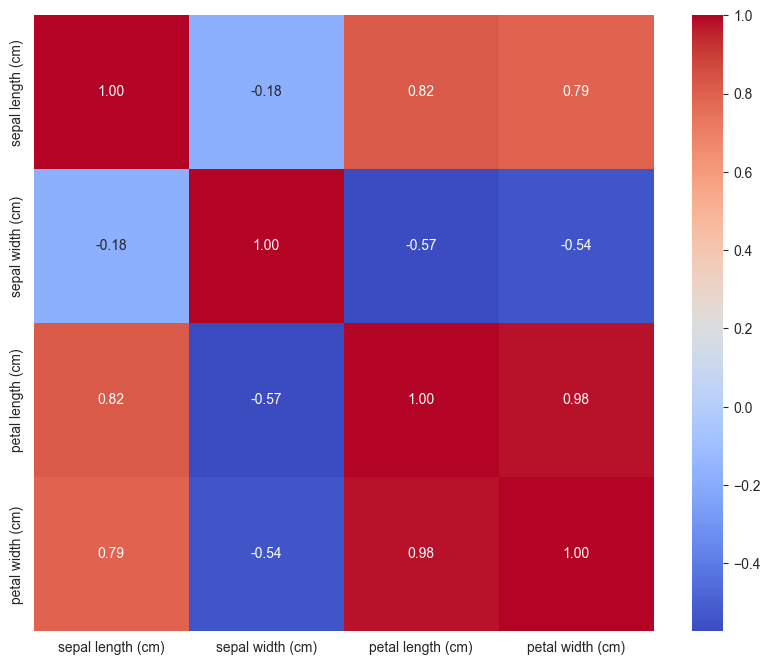

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from Dashboard.data_preprocessing import load_and_preprocess_data


X_train, X_test, y_train, y_test, task = load_and_preprocess_data()


# Assuming 'category_column' is your categorical column
label_encoder = LabelEncoder()
X_train['sex'] = label_encoder.fit_transform(X_train['sex'])

# Then calculate the correlation matrix
correlation_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()



## Experiment 1

In [7]:
print(y_train.describe())

count    353.000000
mean       0.020794
std        1.012568
min       -1.649092
25%       -0.857840
50%       -0.131445
75%        0.802492
max        2.514710
Name: target, dtype: float64


MSE Train: 0.47059960764395203, MSE Test: 0.4547642929721244


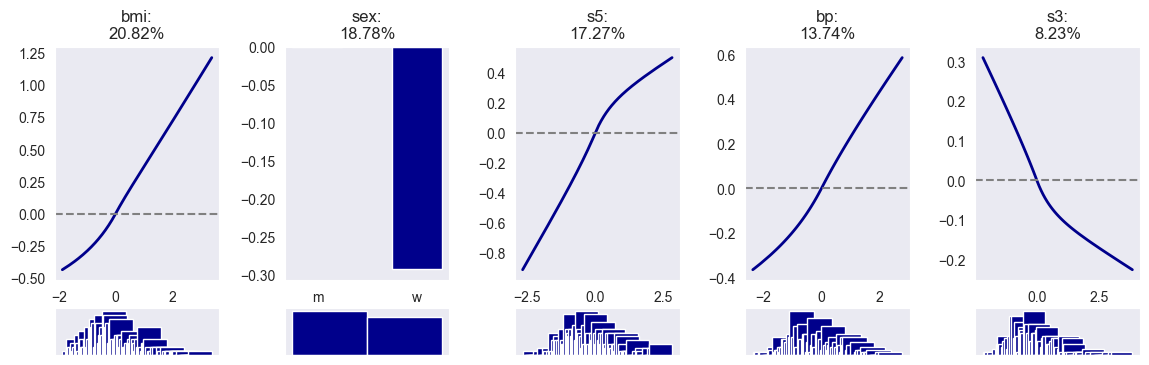

In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score

X_train, X_test, y_train, y_test, task = load_and_preprocess_data()
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

adapter.model.plot_single(show_n=5)



In [6]:
# Assumption: BMI has an effect on BP
# Step 1: Get predictions for feature_1 (BMI)

feature_1 = "bmi"
shape_functions_dict = adapter.model.get_shape_functions_as_dict()

i = adapter.model.feature_names.index(feature_1)
feat_values = np.array(X_train[feature_1])
#adapter.model._get_pred_feature_1_of_i(i, np.array(X_train))
#y = torch.tensor(updated_data[feature]['y'], dtype=torch.float64)
if adapter.model.task == "classification":
    pred_feature_1 = adapter.model.init_classifier.coef_[0, i] * feat_values
else:
    pred_feature_1 = adapter.model.init_classifier.coef_[i] * feat_values

if isinstance(pred_feature_1, np.ndarray):
    pred_feature_1 = torch.from_numpy(pred_feature_1).float()

for regressor, boost_rate in zip(adapter.model.regressors, adapter.model.boosting_rates):
    pred_feature_1 += (
        boost_rate
        * regressor.predict_single(torch.tensor(feat_values.reshape(-1, 1), dtype=torch.float), i).squeeze()
    ).cpu()
print(pred_feature_1)

tensor([ 0.0993, -0.1344,  0.3832, -0.2327, -0.3606, -0.2538,  0.1661,  0.5266,
         0.2955, -0.1274, -0.3720,  0.1578, -0.3325,  0.7913, -0.4074,  0.1661,
        -0.2590, -0.2327, -0.2739,  0.1578,  0.2069, -0.2381,  0.3274, -0.3022,
         0.4230,  0.1162, -0.0906, -0.0829, -0.0750, -0.0336,  0.1246,  0.1906,
        -0.2434, -0.2160,  0.1496, -0.1203, -0.0506,  0.0736, -0.2434, -0.0750,
        -0.4006, -0.0160, -0.2788,  0.3514,  0.2554,  0.6466, -0.0829,  0.8316,
        -0.0506,  0.0114,  0.8639, -0.2590,  0.1413,  0.4549, -0.2836,  0.3673,
         0.0474, -0.2102,  0.4151, -0.0422, -0.0750,  0.1988,  0.9691,  0.1162,
        -0.0070, -0.2102,  0.0385,  0.0822, -0.2102, -0.2487,  0.0205, -0.1803,
        -0.3644, -0.2538, -0.2883, -0.2160,  0.0205,  0.3514, -0.3198, -0.2487,
        -0.1203, -0.0906, -0.4366, -0.1803,  0.1825,  0.4708, -0.0589,  0.6066,
         0.4629,  0.4310, -0.1803,  0.0385,  0.0562, -0.1925, -0.2883, -0.0336,
        -0.2538, -0.3606,  0.5346,  0.21

In [7]:
# Step 2: Adjust overall predictions by subtracting the predictions of feature_1
y_train_adjusted = y_train - np.array(pred_feature_1)
# Prepare new X column
X_train_except_feat_1 = X_train.drop(columns=[feature_1])

MSE Train: 0.4664780078636073


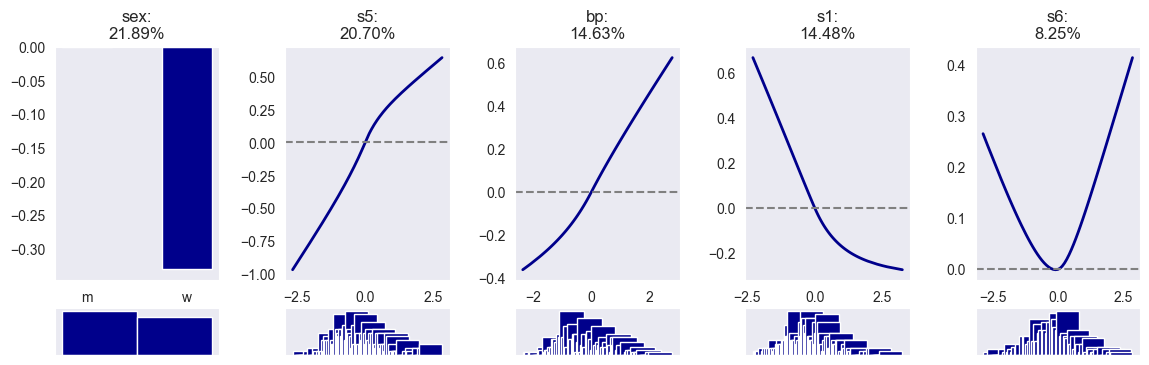

In [8]:
# Step 3:
# Retrain all other features with y_train_adjusted
adapter_adjusted_feat_1 = ModelAdapter(task)
adapter_adjusted_feat_1.fit(X_train_except_feat_1, y_train_adjusted)
y_train_pred_adjusted= adapter_adjusted_feat_1.predict(X_train_except_feat_1)
if task == "regression":
    mse_train_adjusted_feat_1 = mean_squared_error(y_train_adjusted, y_train_pred_adjusted)
    print(f"MSE Train: {mse_train_adjusted_feat_1}")
else:
    f1_train_adjusted_feat_1 = f1_score(y_train_adjusted, y_train_pred_adjusted, average='weighted')
    print(f"Train F1 Score: {f1_train_adjusted_feat_1}")

adapter_adjusted_feat_1.model.plot_single(show_n=5)

In [14]:
# Metrics to quantify the change
if task == "regression":
    main_metric = mse_train - mse_train_adjusted_feat_1
else:
    main_metric = f1_train - f1_train_adjusted_feat_1
print(f"Differenz in MSE or f1: {main_metric}")
shape_functions_dict_adjusted_feat_1 = adapter_adjusted_feat_1.get_shape_functions_as_dict()

correlations_with_feature_1 = correlation_matrix[feature_1]
correlations_with_feature_1 = correlations_with_feature_1.drop(feature_1)
results_columns = ['metadata'] + list(correlations_with_feature_1.index)  # Correlation indices as columns
results_df = pd.DataFrame(columns=results_columns)
results_df.loc[0] = ["Correlations"] + correlations_with_feature_1.tolist()



comparison_results = []

# Iterate through the original dictionary
for original_feature in shape_functions_dict:
    # Skip 'bmi' feature
    if original_feature['name'] == feature_1:
        continue
    
    # Find corresponding feature in the adjusted dictionary
    adjusted_feature = next((item for item in shape_functions_dict_adjusted_feat_1 if item['name'] == original_feature['name']), None)
    
    # Continue if the feature is not found in the adjusted dictionary
    if not adjusted_feature:
        continue
    
    # Calculate average of y values for both features
    avg_y_original = sum(original_feature['y']) / len(original_feature['y'])
    avg_y_adjusted = sum(adjusted_feature['y']) / len(adjusted_feature['y'])
    
    # Calculate the most distant points by finding the maximum absolute difference between corresponding y values
    max_diff = max(abs(o - a) for o, a in zip(original_feature['y'], adjusted_feature['y']))
    
    # Compare avg_effect
    avg_effect_diff = adjusted_feature['avg_effect'] - original_feature['avg_effect']
    
    # Store the comparison results
    comparison_results.append({
        'feature': original_feature['name'],
        'avg_y_original': avg_y_original,
        'avg_y_adjusted': avg_y_adjusted,
        'max_diff_y': max_diff,
        'avg_effect_diff': avg_effect_diff,
    })

new_row = {'metadata': 'Avg Effect Diff'}
max_diff_row = {'metadata': 'Max Diff Y'}

for result in comparison_results:
    feature = result['feature']
    avg_effect_diff = result['avg_effect_diff']
    max_diff = result['max_diff_y']
    new_row[feature] = avg_effect_diff
    max_diff_row[feature] = max_diff
    # For features not in comparison_results, set to None or another placeholder value
    for col in results_df.columns:
        if col not in new_row:
            new_row[col] = None
        if col not in max_diff_row:
            max_diff_row[col] = None
new_row_df = pd.DataFrame([new_row])
max_diff_row_df = pd.DataFrame([max_diff_row])

# Append the new row to the DataFrame
results_df = pd.concat([results_df, new_row_df], ignore_index=True)
results_df = pd.concat([results_df, max_diff_row_df], ignore_index=True)
results_df
dataset="blood_pressure"
effect="no_effect"


path = os.path.join(os.getcwd(), f"freeze_weights_{dataset}_{effect}.csv")

results_df.to_csv(path, decimal=',', index=False)

Differenz in MSE or f1: 0.004121599780344709


## Experiment 2

MSE Train: 0.47059960764395203, MSE Test: 0.4547642929721244


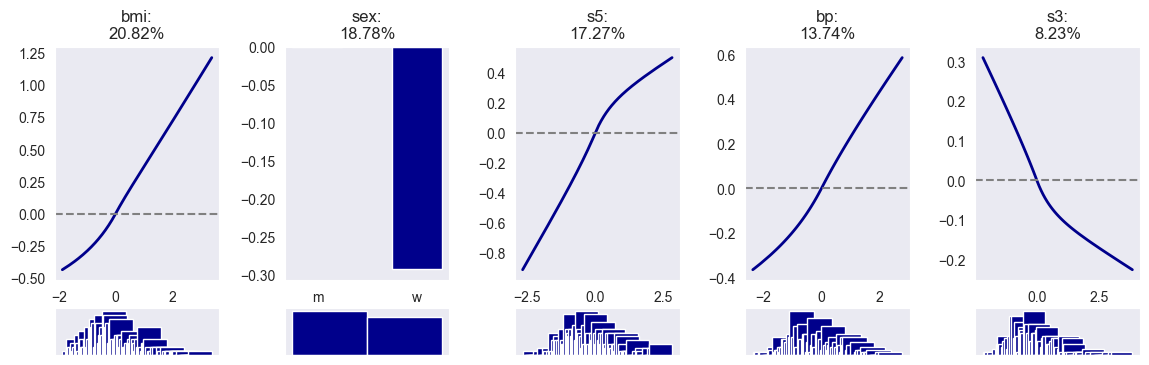

In [16]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score

X_train, X_test, y_train, y_test, task = load_and_preprocess_data()
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

adapter.model.plot_single(show_n=5)



C:\Users\jfill\PycharmProjects\Masterthesis\Dashboard\model_adapter.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat = torch.tensor(y_hat, dtype=torch.float32)


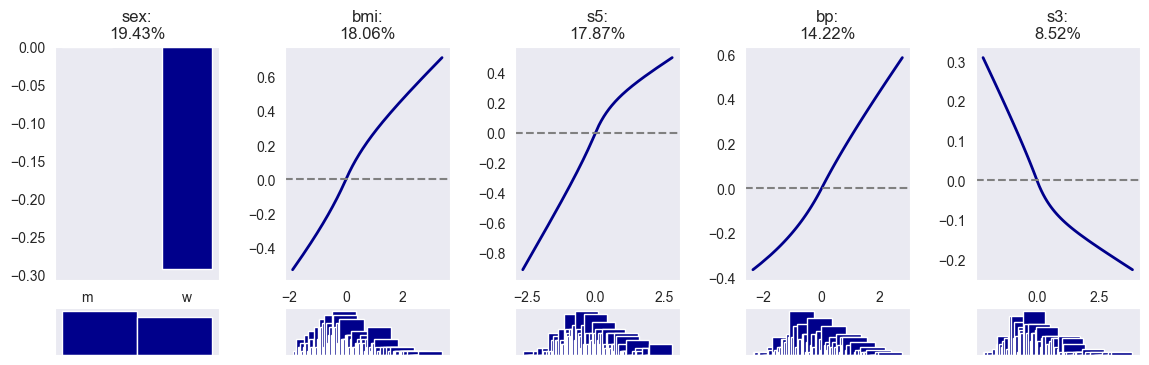

In [20]:
# Step 1: Adjust weights for feature_1 (BMI
# We cut off the positive effect at 0.5

features_to_change = ['bmi']
shape_functions_dict = adapter.model.get_shape_functions_as_dict()

# this part is already given in the flask application
feature_current_state = {}
for feature in shape_functions_dict:
    name = feature['name']
    y_value = feature['y']
    feature_current_state[name] = y_value

updated_data = {}

for feature in shape_functions_dict:
    name = feature['name']
    x_values = feature['x']
    if name in features_to_change:
        # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
        if feature["datatype"] == "numerical":
            y_values = np.where(np.array(feature_current_state[name]) > 0.5, 0.5, feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': y_values.tolist(), 'datatype': 'numerical'}       
        else:
            y_values = np.array(feature_current_state[name])
            #updated_data[name] = {'x': x_values, 'y': np.array([-2]), 'datatype': 'categorical'}
            updated_data[name] = {'x': x_values, 'y': y_values, 'datatype': 'categorical'}
    else:
        if feature['datatype'] == 'numerical':
            updated_data[name] = {'x': x_values, 'y': feature['y'].tolist(), 'datatype': 'numerical'}
        else:
            updated_data[name] = {'x': x_values, 'y': feature['y'], 'datatype': 'categorical'}
            #y_values = feature_current_state[name]
#spline, retrain_feature
adapter = adapter.adapt(features_to_change, updated_data, "retrain_feature", X_train, y_train)
adapter.plot_single(show_n=5)


In [26]:
# Assumption: BMI has an effect on BP
# Step 2: Get predictions for feature_1 (BMI)

feature_1 = "bmi"
shape_functions_dict = adapter.get_shape_functions_as_dict()

i = adapter.feature_names.index(feature_1)
feat_values = np.array(X_train[feature_1])
#adapter.model._get_pred_feature_1_of_i(i, np.array(X_train))
#y = torch.tensor(updated_data[feature]['y'], dtype=torch.float64)
if adapter.task == "classification":
    pred_feature_1 = adapter.init_classifier.coef_[0, i] * feat_values
else:
    pred_feature_1 = adapter.init_classifier.coef_[i] * feat_values

if isinstance(pred_feature_1, np.ndarray):
    pred_feature_1 = torch.from_numpy(pred_feature_1).float()

for regressor, boost_rate in zip(adapter.regressors, adapter.boosting_rates):
    pred_feature_1 += (
        boost_rate
        * regressor.predict_single(torch.tensor(feat_values.reshape(-1, 1), dtype=torch.float), i).squeeze()
    ).cpu()
print(pred_feature_1)

tensor([ 0.0866, -0.1309,  0.2857, -0.2394, -0.4073, -0.2648,  0.1392,  0.3688,
         0.2303, -0.1237, -0.4242,  0.1329, -0.3671,  0.5081, -0.4795,  0.1392,
        -0.2711, -0.2394, -0.2896,  0.1329,  0.1694, -0.2458,  0.2509, -0.3260,
         0.3095,  0.1003, -0.0866, -0.0789, -0.0712, -0.0314,  0.1070,  0.1575,
        -0.2522, -0.2200,  0.1266, -0.1164, -0.0476,  0.0651, -0.2522, -0.0712,
        -0.4686, -0.0149, -0.2958,  0.2660,  0.2034,  0.4336, -0.0789,  0.5284,
        -0.0476,  0.0105,  0.5445, -0.2711,  0.1202,  0.3282, -0.3019,  0.2759,
         0.0425, -0.2134,  0.3048, -0.0395, -0.0712,  0.1635,  0.5963,  0.1003,
        -0.0064, -0.2134,  0.0347,  0.0724, -0.2134, -0.2585,  0.0187, -0.1800,
        -0.4129, -0.2648, -0.3079, -0.2200,  0.0187,  0.2660, -0.3496, -0.2585,
        -0.1164, -0.0866, -0.5282, -0.1800,  0.1515,  0.3373, -0.0555,  0.4123,
         0.3328,  0.3142, -0.1800,  0.0347,  0.0502, -0.1935, -0.3079, -0.0314,
        -0.2648, -0.4073,  0.3732,  0.17

MSE Train: 0.4741471747688996


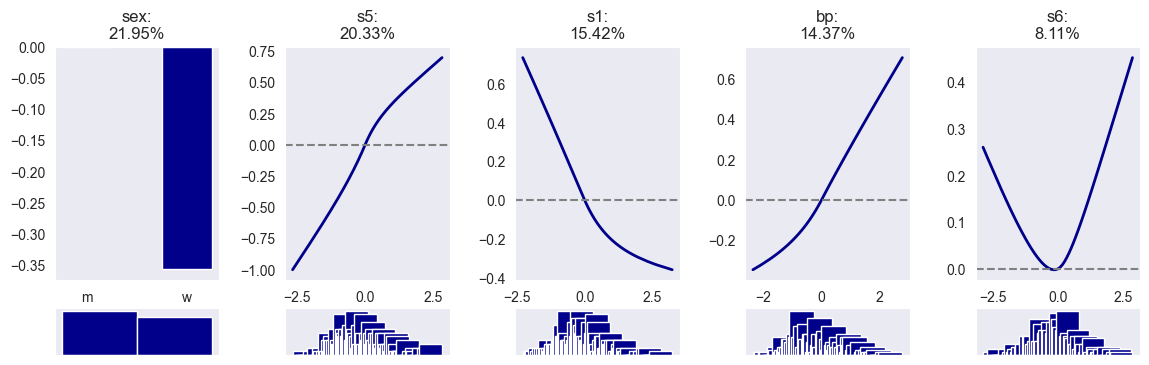

In [28]:
# Step 2: Adjust overall predictions by subtracting the predictions of feature_1
y_train_adjusted = y_train - np.array(pred_feature_1)
# Prepare new X column
X_train_except_feat_1 = X_train.drop(columns=[feature_1])
# Step 3:
# Retrain all other features with y_train_adjusted
adapter_adjusted_feat_1 = ModelAdapter(task)
adapter_adjusted_feat_1.fit(X_train_except_feat_1, y_train_adjusted)
y_train_pred_adjusted = adapter_adjusted_feat_1.predict(X_train_except_feat_1)
if task == "regression":
    mse_train_adjusted_feat_1 = mean_squared_error(y_train_adjusted, y_train_pred_adjusted)
    print(f"MSE Train: {mse_train_adjusted_feat_1}")
else:
    f1_train_adjusted_feat_1 = f1_score(y_train_adjusted, y_train_pred_adjusted, average='weighted')
    print(f"Train F1 Score: {f1_train_adjusted_feat_1}")

adapter_adjusted_feat_1.model.plot_single(show_n=5)

In [29]:
# Metrics to quantify the change
if task == "regression":
    main_metric = mse_train - mse_train_adjusted_feat_1
else:
    main_metric = f1_train - f1_train_adjusted_feat_1
print(f"Differenz in MSE or f1: {main_metric}")
shape_functions_dict_adjusted_feat_1 = adapter_adjusted_feat_1.get_shape_functions_as_dict()

correlations_with_feature_1 = correlation_matrix[feature_1]
correlations_with_feature_1 = correlations_with_feature_1.drop(feature_1)
results_columns = ['metadata'] + list(correlations_with_feature_1.index)  # Correlation indices as columns
results_df = pd.DataFrame(columns=results_columns)
results_df.loc[0] = ["Correlations"] + correlations_with_feature_1.tolist()



comparison_results = []

# Iterate through the original dictionary
for original_feature in shape_functions_dict:
    # Skip 'bmi' feature
    if original_feature['name'] == feature_1:
        continue
    
    # Find corresponding feature in the adjusted dictionary
    adjusted_feature = next((item for item in shape_functions_dict_adjusted_feat_1 if item['name'] == original_feature['name']), None)
    
    # Continue if the feature is not found in the adjusted dictionary
    if not adjusted_feature:
        continue
    
    # Calculate average of y values for both features
    avg_y_original = sum(original_feature['y']) / len(original_feature['y'])
    avg_y_adjusted = sum(adjusted_feature['y']) / len(adjusted_feature['y'])
    
    # Calculate the most distant points by finding the maximum absolute difference between corresponding y values
    max_diff = max(abs(o - a) for o, a in zip(original_feature['y'], adjusted_feature['y']))
    
    # Compare avg_effect
    avg_effect_diff = adjusted_feature['avg_effect'] - original_feature['avg_effect']
    
    # Store the comparison results
    comparison_results.append({
        'feature': original_feature['name'],
        'avg_y_original': avg_y_original,
        'avg_y_adjusted': avg_y_adjusted,
        'max_diff_y': max_diff,
        'avg_effect_diff': avg_effect_diff,
    })

new_row = {'metadata': 'Avg Effect Diff'}
max_diff_row = {'metadata': 'Max Diff Y'}

for result in comparison_results:
    feature = result['feature']
    avg_effect_diff = result['avg_effect_diff']
    max_diff = result['max_diff_y']
    new_row[feature] = avg_effect_diff
    max_diff_row[feature] = max_diff
    # For features not in comparison_results, set to None or another placeholder value
    for col in results_df.columns:
        if col not in new_row:
            new_row[col] = None
        if col not in max_diff_row:
            max_diff_row[col] = None
new_row_df = pd.DataFrame([new_row])
max_diff_row_df = pd.DataFrame([max_diff_row])

# Append the new row to the DataFrame
results_df = pd.concat([results_df, new_row_df], ignore_index=True)
results_df = pd.concat([results_df, max_diff_row_df], ignore_index=True)
results_df
dataset="diabetes"
effect="with_effec"


path = os.path.join(os.getcwd(), f"freeze_weights_{dataset}_{effect}.csv")

results_df.to_csv(path, decimal=',', index=False)

Differenz in MSE or f1: -0.0035475671249475815
